# Frequent Mutations
## ESM-FCN_BE
Histogram figure of frequent mutations for ESM-FCN_BE, version G. We'll choose this model because it was the best mean performance between binding and expression.

In [23]:
import pandas as pd

log_dir = "../../src/pnlp/ESM_TL/logs/"

info_df = pd.read_csv("/data/spike_ml/Spike_NLP-Lightning/notebooks/models/scatter/ESM_TL/esm_fcn_be/esm_fcn_be.G-predicted_vs_measured.values.csv")
info_df.head(5)

,seq_id,binding_measured_value,binding_predicted_value,expression_measured_value,expression_predicted_value,mode
0,SARS-CoV-2-T63S_Y121P_T201S,9.380,9.533784,9.07,9.149452,test
1,SARS-CoV-2-S36E_Y143L,10.270,10.240893,9.85,10.214157,test
2,SARS-CoV-2-Y39L_F99C,8.985,7.783888,8.28,8.005304,test
3,SARS-CoV-2-V11C_I104Y,9.590,9.248444,7.68,8.067461,test
4,SARS-CoV-2-K56L_D90T,10.290,10.306768,9.36,8.985881,test


### Binding

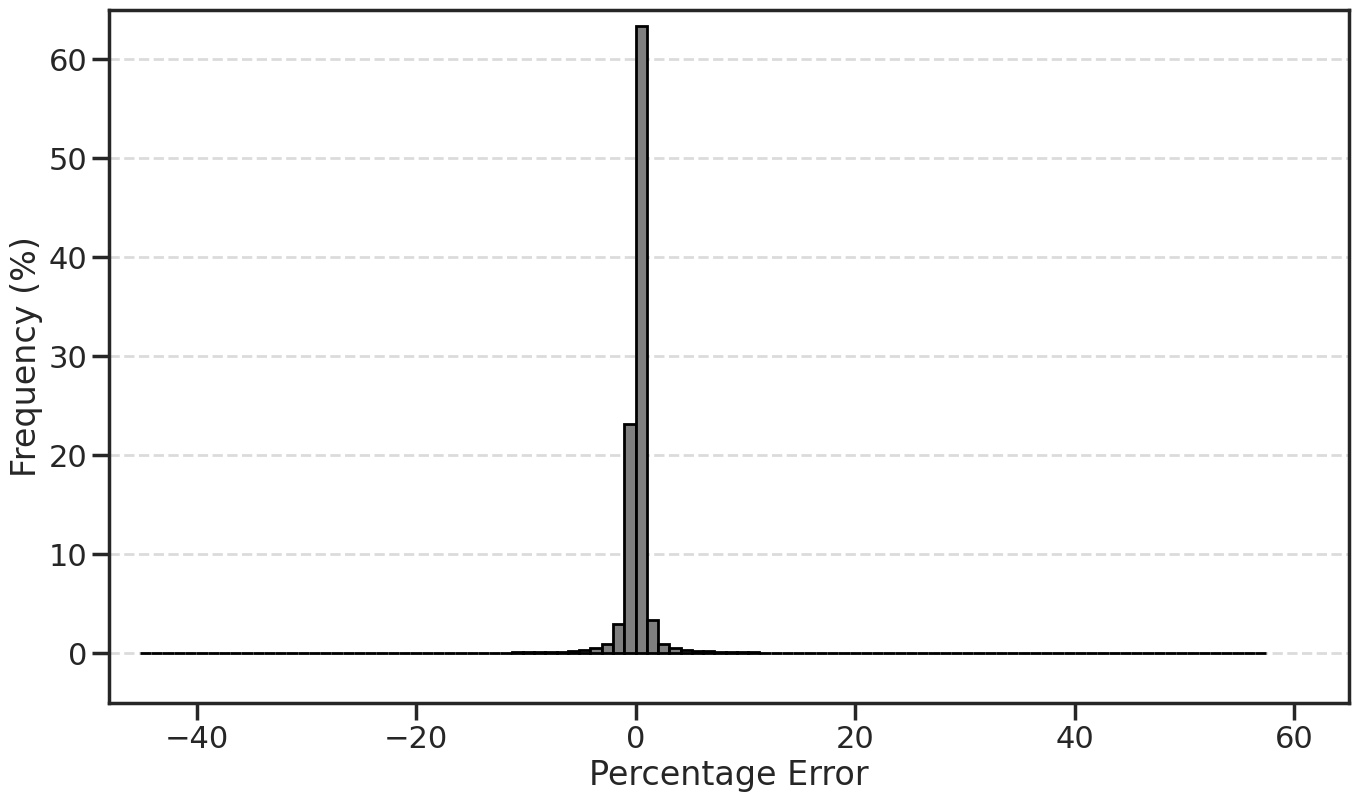

In [24]:
# Binding
binding_df = info_df[["seq_id", "binding_predicted_value", "binding_measured_value", "mode"]].copy()
binding_df["percentage_error"] = ((info_df["binding_predicted_value"] - info_df["binding_measured_value"]) / info_df["binding_measured_value"]) * 100
binding_df.head(5)

# Plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')
sns.set_context('poster')
plt.subplots(figsize=(16, 9)) 

plt.hist(
    binding_df["percentage_error"], 
    bins=100, 
    weights=[100 / len(binding_df)] * len(binding_df), 
    edgecolor='black', 
    color='tab:grey',
    #linewidth=1
)

plt.xlim(-48, 65)  
plt.xlabel("Percentage Error")
plt.ylim(-5, 65)
plt.ylabel("Frequency (%)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

save_path = "bar/esm_fcn_be.G.binding-percent_error"
plt.savefig(f"{save_path}.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.savefig(f"{save_path}.png", format='png', dpi=300, bbox_inches='tight')

Now let's pull the outliers from top and bottom 2.5%.

In [25]:
lower_bound = binding_df['percentage_error'].quantile(0.025)
upper_bound = binding_df['percentage_error'].quantile(0.975)

outliers = binding_df[(binding_df['percentage_error'] < lower_bound) | (binding_df['percentage_error'] > upper_bound)].reset_index(drop=True)
outliers.head(5)

,seq_id,binding_predicted_value,binding_measured_value,mode,percentage_error
0,SARS-CoV-2-Y39L_F99C,7.783888,8.985,test,-13.367967
1,SARS-CoV-2-V11C_I104Y,9.248444,9.590,test,-3.561591
2,SARS-CoV-2-N40S_R127I,7.235892,6.140,test,17.848411
3,SARS-CoV-2-N40M_I72T_P149E,9.002502,9.430,test,-4.533381
4,SARS-CoV-2-C6W_G116S_G155V,7.275959,6.000,test,21.265984


We need to adjust the seq_id to acquire the mutations from the data. 

The Spike receptor binding domain (RBD) from SARS-CoV-2 (isolate Wuhan-Hu-1, GenBank : MN908947, residues N331-T531) (checked [Deep Mutational Scanning of SARS-CoV-2 Receptor Binding Domain Reveals Constraints on Folding and ACE2 Binding](https://www.cell.com/cell/fulltext/S0092-8674(20)31003-5?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867420310035%3Fshowall%3Dtrue)). So we need to add 330 to get the RBD site (data not 0 indexed).

In [26]:
df = outliers.copy()
df['target'] = df['seq_id'].str.rsplit('-', n=1).str[0]
df['aa_substitutions'] = df['seq_id'].str.rsplit('-', n=1).str[1].str.rsplit('_')
print(len(df))

df = df.explode('aa_substitutions')
print(len(df))

df['RBD_mutation_site'] = df['aa_substitutions'].str.extract(r'(\d+)').astype(int) + 330 # Extract numeric site, RBD site
df['original_aa'] = df['aa_substitutions'].str[0]
df['new_aa'] = df['aa_substitutions'].str[-1]
df['aa_sub'] = df['original_aa'] + ">" + df['new_aa']
df.head(5)

5144
16929


,seq_id,binding_predicted_value,binding_measured_value,mode,percentage_error,target,aa_substitutions,RBD_mutation_site,original_aa,new_aa,aa_sub
0,SARS-CoV-2-Y39L_F99C,7.783888,8.985,test,-13.367967,SARS-CoV-2,Y39L,369,Y,L,Y>L
0,SARS-CoV-2-Y39L_F99C,7.783888,8.985,test,-13.367967,SARS-CoV-2,F99C,429,F,C,F>C
1,SARS-CoV-2-V11C_I104Y,9.248444,9.590,test,-3.561591,SARS-CoV-2,V11C,341,V,C,V>C
1,SARS-CoV-2-V11C_I104Y,9.248444,9.590,test,-3.561591,SARS-CoV-2,I104Y,434,I,Y,I>Y
2,SARS-CoV-2-N40S_R127I,7.235892,6.140,test,17.848411,SARS-CoV-2,N40S,370,N,S,N>S


Here we will look at the total mutations possible that occur at a particular site across all seq_ids in our outliers. Then we will break it down by amino acid.

In [27]:
from collections import Counter

original_aa_dict = df.groupby('RBD_mutation_site')['original_aa'].apply(lambda x: list(set(x))).to_dict()
new_aa_dict = df.groupby('RBD_mutation_site')['new_aa'].apply(lambda x: list(set(x))).to_dict()

new_aa_total_ct_dict = df.groupby('RBD_mutation_site')['new_aa'].count().to_dict()
#print(f"Per site total mutations: {new_aa_total_ct_dict}")

new_aa_ct_dict = df.groupby('RBD_mutation_site')['new_aa'].apply(lambda x: list(Counter(x).items())).to_dict()
sorted_new_aa_ct_dict = {k: sorted(v, key=lambda x: x[1], reverse=True) for k, v in new_aa_ct_dict.items()}
#print(f"Per site, per new amino acid substitution total: {sorted_new_aa_ct_dict}")

data = []
for site in sorted(new_aa_total_ct_dict.keys()):
    total = new_aa_total_ct_dict[site]
    mutations = sorted_new_aa_ct_dict[site]
    mutation_str = ', '.join([f"{aa}({count})" for aa, count in mutations])
    data.append({
        'RBD Site': site,
        'Original Amino Acid': original_aa_dict[site][0],
        'Total Possible Mutations': total,
        'Amino Acid Substitutions (Count)': mutation_str
    })

possible_mutations_per_site = pd.DataFrame(data)
#print(possible_mutations_per_site.to_string(index=False))

# Sort and display the top 10
possible_mutations_per_site['Total Possible Mutations'] = pd.to_numeric(possible_mutations_per_site['Total Possible Mutations'])
top_10_highest = possible_mutations_per_site.sort_values('Total Possible Mutations', ascending=False).head(10)
print(top_10_highest.to_string(index=False))

 RBD Site Original Amino Acid  Total Possible Mutations                                                                                             Amino Acid Substitutions (Count)
      420                   D                       233 S(26), Y(26), R(25), L(15), F(15), N(15), I(14), H(12), V(12), T(12), G(11), M(11), K(8), E(7), A(7), Q(7), W(6), C(3), P(1)
      531                   T                       226  R(28), K(24), L(20), S(20), M(16), W(13), V(13), A(12), P(12), N(10), I(10), E(9), C(7), Q(7), G(6), F(6), H(5), Y(4), D(4)
      391                   C                       212 L(18), T(17), V(17), S(16), R(15), A(13), K(13), M(13), N(12), G(11), P(11), F(11), E(9), I(9), D(7), Y(7), H(6), W(5), Q(2)
      437                   N                       210    S(22), P(20), T(20), L(19), R(15), I(14), V(12), G(11), D(10), H(9), F(8), K(8), Q(7), W(7), A(7), M(7), Y(6), E(4), C(4)
      436                   W                       188       R(27), V(20), T(19), L(17), S(16)

Now, we will find the highest score predicted score per site. We save the measured value, and we can use this as a coordinate value associated with it's percentage error.

In [28]:
# Group by 'RBD_mutation_site' and extract all binding_predicted_value scores for each site
all_scores_dict = df.groupby('RBD_mutation_site').apply(
    lambda x: x[['new_aa', 'binding_measured_value', 'binding_predicted_value', 'percentage_error']].values.tolist()
).to_dict()

# Find the highest binding_predicted_value score for each site
highest_scores = {site: max(scores, key=lambda x: x[2])[2] if scores else 0 for site, scores in all_scores_dict.items()}

data = []
for site, max_score in highest_scores.items():
    total = new_aa_total_ct_dict[site]
    scores = all_scores_dict.get(site, [])
    aa_str = ', '.join([f'{aa}' for aa, m_score, p_score, perc_error in scores])
    scores_str = ', '.join([f'{perc_error:.2f}' for aa, m_score, p_score, perc_error in scores])
    data.append({
        'RBD Site': site,
        'Total Mutations': total,
        'Original Amino Acid': original_aa_dict[site][0],
        'Highest Predicted Binding Value': f'{max_score:.2f}',
        'Amino Acid Substitutions': aa_str,
        'Perc Error': scores_str
    })

b_all_scores_per_site = pd.DataFrame(data)
#print(all_scores_per_site.to_string(index=False))

# Sort and display the top 10
b_all_scores_per_site['Highest Predicted Binding Value'] = pd.to_numeric(b_all_scores_per_site['Highest Predicted Binding Value'])
b_top_10_highest = b_all_scores_per_site.sort_values('Highest Predicted Binding Value', ascending=False).head(10)
print(b_top_10_highest.to_string(index=False))

sorted([[s, aa] for s, aa in zip(b_top_10_highest['RBD Site'].to_list(), b_top_10_highest['Original Amino Acid'].to_list())])

 RBD Site  Total Mutations Original Amino Acid  Highest Predicted Binding Value                                                                                                                                                                                                                                                                                                                                                                                                                                               Amino Acid Substitutions                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

/tmp/ipykernel_3513920/2937275485.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_scores_dict = df.groupby('RBD_mutation_site').apply(


[[333, 'T'],
 [335, 'L'],
 [366, 'S'],
 [384, 'P'],
 [394, 'N'],
 [439, 'N'],
 [452, 'L'],
 [462, 'K'],
 [490, 'F'],
 [520, 'A']]

Use the original aa at that position. The error bar here is the percent of mutations that leads to increased (+) or decreased (-) binding (or mutation in a separate figure) with any of the mutations this position was invoved.
- First column is position, second one is AA, third column is impact.
- impact > 0 means "increase." that is a ratio. so 0.5 means 50% increase
- 1.0 means doubled.
- impact <0 means "decrease". -0.5 means half.

In [29]:
import pandas as pd
import numpy as np

def calculate_impact(data):
    data = data.copy()

    # Convert percent error strings to floats
    data['Perc Error'] = data['Perc Error'].str.split(', ').apply(lambda x: [float(i) for i in x])
    
    # Calculate impact
    def impact(errors):
        total = len(errors)
        increased = sum(1 for e in errors if e > 0)
        decreased = sum(1 for e in errors if e < 0)
        return {
            'increased': (increased / total) * 100,
            'decreased': (decreased / total) * 100,
            'neutral': ((total - increased - decreased) / total) * 100,
            'impact': (increased - decreased) / total
        }
    
    results = data.apply(lambda row: impact(row['Perc Error']), axis=1)
    
    impact_df = pd.DataFrame(results.tolist(), index=data.index)
    
    # Add RBD Site and Original Amino Acid columns
    impact_df['RBD Site'] = data['RBD Site']
    impact_df['Original Amino Acid'] = data['Original Amino Acid']
    columns_order = ['RBD Site', 'Original Amino Acid', 'increased', 'decreased', 'neutral', 'impact']
    impact_df = impact_df[columns_order]

    impact_df = impact_df.sort_values('RBD Site')
    
    return impact_df

b_impact_results = calculate_impact(b_all_scores_per_site)
print(b_impact_results.head(5))

   RBD Site Original Amino Acid  increased  decreased  neutral    impact
0       331                   N  48.484848  51.515152      0.0 -0.030303
1       332                   I  40.845070  59.154930      0.0 -0.183099
2       333                   T  48.818898  51.181102      0.0 -0.023622
3       334                   N  60.416667  39.583333      0.0  0.208333
4       335                   L  50.000000  50.000000      0.0  0.000000


Theses are residues from the 6MOJ paper that indicates that the RBD-ACE2 complex forming interface #1 is the biological complex. 

In [30]:
interface_residues = [403, 417,	445, 446, 449, 453, 455, 456, 473, 475, 476, 477, 484, 485, 486, 487, 489, 490, 493, 496, 498, 500, 501, 502, 503, 505]

TOP INCREASING IMPACT Binding:
     RBD Site Original Amino Acid  increased  decreased  neutral    impact
197       334                   N  60.416667  39.583333      0.0  0.208333
195       336                   C  60.402685  39.597315      0.0  0.208054
176       355                   R  60.317460  39.682540      0.0  0.206349
129       402                   I  62.068966  37.931034      0.0  0.241379
126       405                   D  62.962963  37.037037      0.0  0.259259
93        438                   S  61.904762  38.095238      0.0  0.238095
88        443                   S  61.946903  38.053097      0.0  0.238938
83        448                   N  63.333333  36.666667      0.0  0.266667
69        462                   K  64.406780  35.593220      0.0  0.288136
68        463                   P  63.829787  36.170213      0.0  0.276596
56        475                   A  62.500000  37.500000      0.0  0.250000
37        494                   S  64.444444  35.555556      0.0  0.2

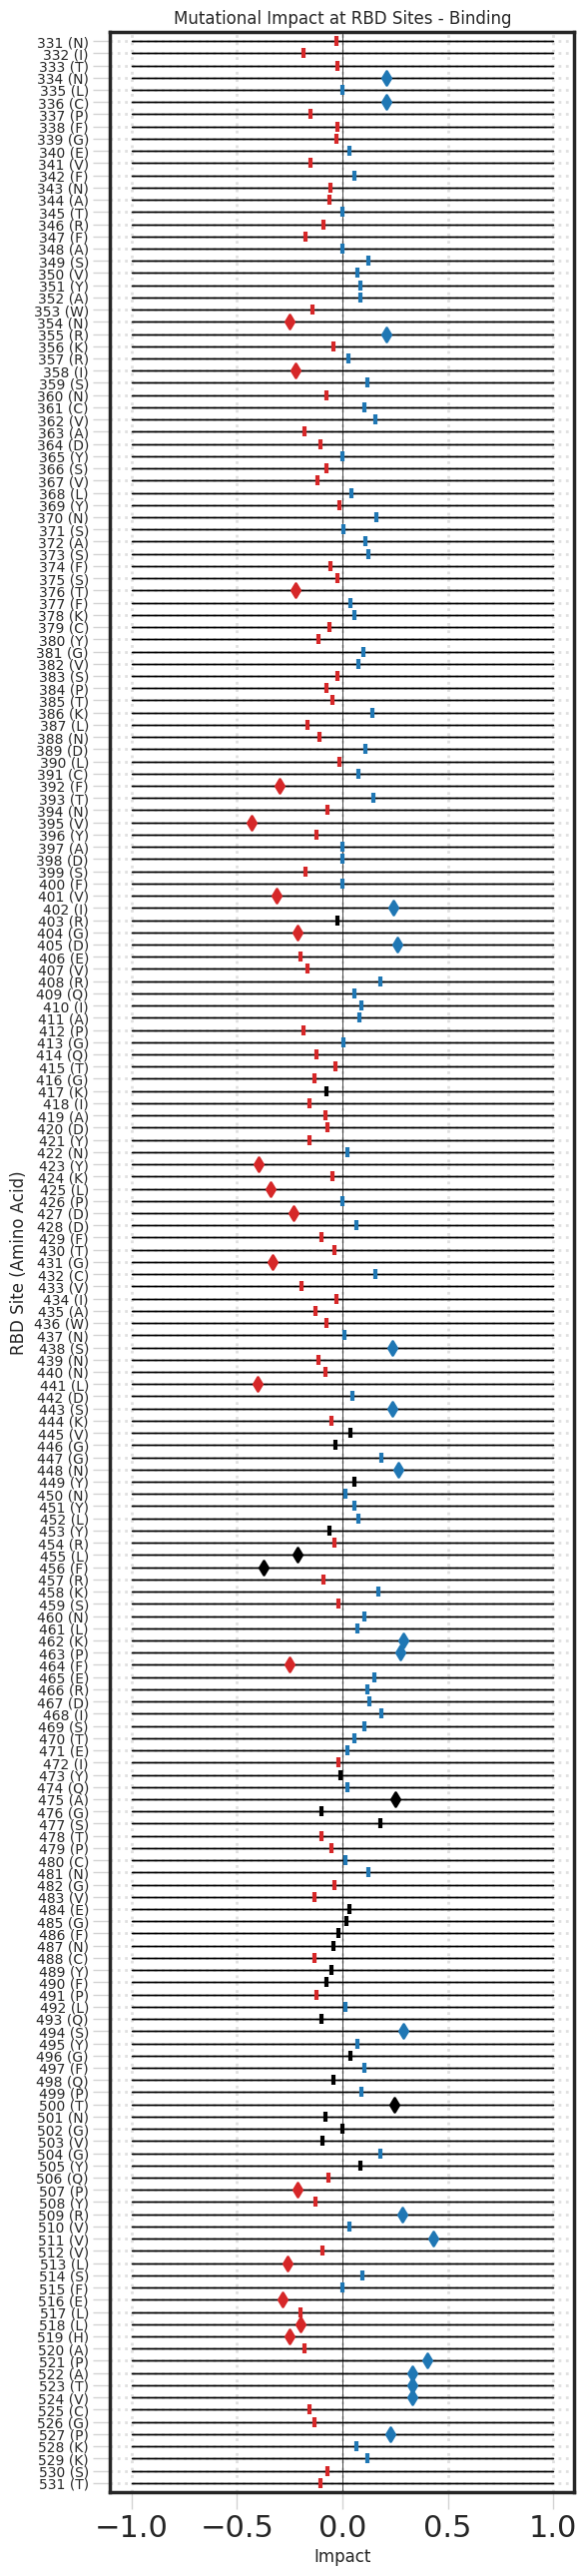

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_mutational_impact(impact_results_df, BorE, interface_residues):
    df = impact_results_df.sort_values('RBD Site', ascending=False).reset_index(drop=True).copy()

    # Find the top n increasing impact
    top_10_indices = df['impact'].nlargest(20).index.sort_values(ascending=False)    
    print(f"TOP INCREASING IMPACT {BorE}:\n{df.loc[top_10_indices].to_string()}\n")
    #print(df.loc[top_10_indices, 'RBD Site'].to_list())

    # Find the top n decreasing impact
    bottom_10_indices = df['impact'].nsmallest(20).index.sort_values(ascending=False)    
    print(f"TOP DECREASING IMPACT {BorE}:\n{df.loc[bottom_10_indices].to_string()}")

    plt.figure(figsize=(6, 32))

    # Track y-tick positions and labels
    yticks = []
    ytick_labels = []

    # Plot one line per RBD site
    for i, row in df.iterrows():
        rbd_site = row['RBD Site'] 
        aa = row['Original Amino Acid']                          
        impact = row['impact']

        # Background horizontal reference line
        plt.plot([-1, 1], [i, i], color='black', linewidth=1, zorder=1)

        # Color depending on impact
        line_color = 'tab:red' if impact < 0 else 'tab:blue'

        # Marker 
        if row.name in top_10_indices:
            marker = 'd'  # Shape for top 10
        elif row.name in bottom_10_indices:
            marker = 'd'  # Shape for bottom 10
        else:
            marker = '|'  # Vertical line for others

        # Background line
        plt.plot([-1, 1], [i, i], color='black', linewidth=1, zorder=1)

        # Plot marker
        if marker is not None:
            plt.scatter(
                impact,
                i,
                color='black' if rbd_site in interface_residues else line_color,
                marker=marker,
                s=50,
                zorder=3
            )

        yticks.append(i)
        ytick_labels.append(f"{rbd_site} ({aa})")

    # Axes and title
    plt.title(f'Mutational Impact at RBD Sites - {BorE}', fontsize=12)
    plt.xlabel('Impact', fontsize=12)
    plt.ylabel('RBD Site (Amino Acid)', fontsize=12)

    # Set axis ticks
    plt.yticks(yticks, ytick_labels)
    plt.tick_params(axis='y', which='major', labelsize=10)
    plt.ylim(-0.75, len(yticks) - 0.25)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

    plt.tick_params(
        axis='both',
        direction='out',
        width=1,
        left=True,
        right=False,
        bottom=True,
        top=False,
        color='lightgrey'
    )

    plt.grid(True, linestyle=':', color='lightgrey', alpha=0.7)

    # Save plot
    save_as = f"mutation/mutational_impact.G.{BorE.lower()}"
    plt.savefig(f"{save_as}.pdf", format='pdf', bbox_inches='tight')
    plt.savefig(f"{save_as}.png", format='png', bbox_inches='tight')

plot_mutational_impact(b_impact_results, "Binding", interface_residues)

### Expression

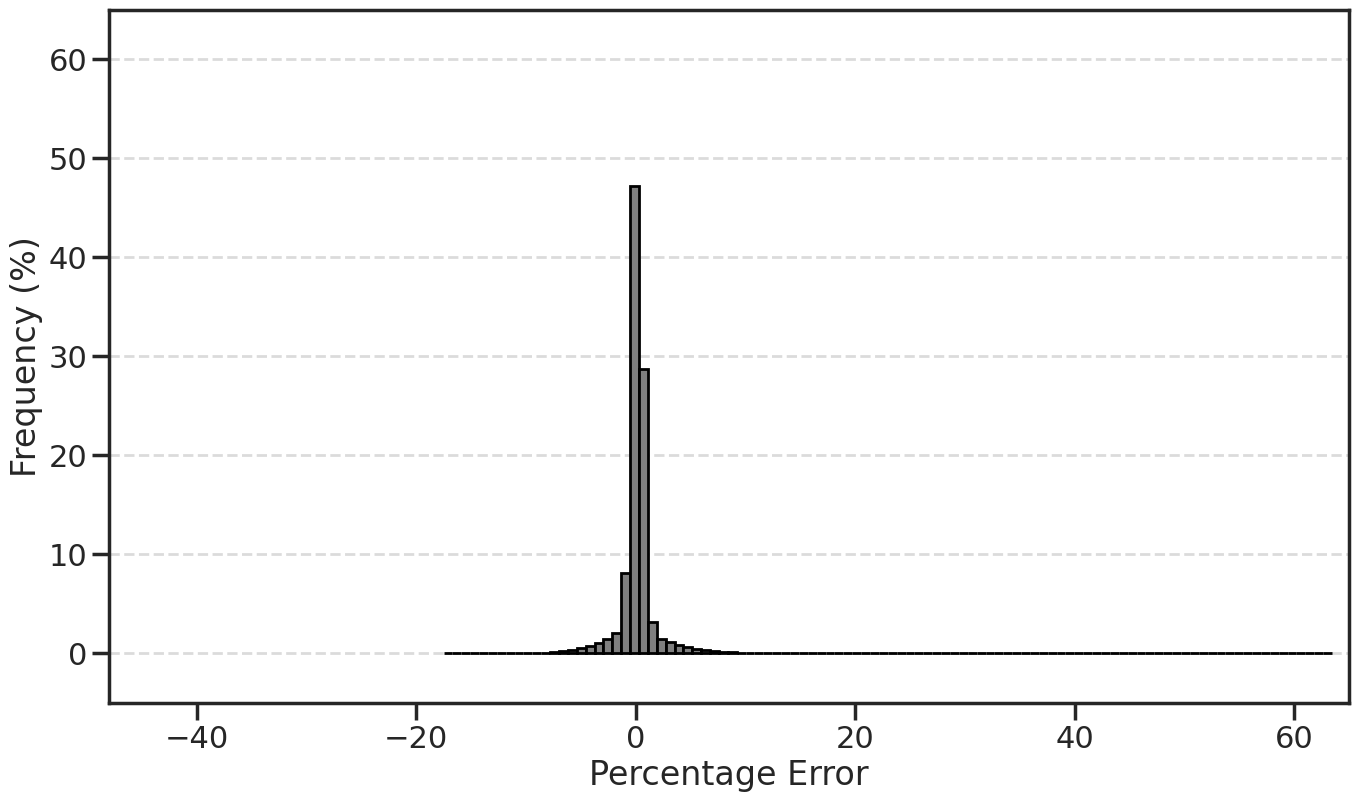

In [32]:
# Expression
expression_df = info_df[["seq_id", "expression_predicted_value", "expression_measured_value", "mode"]].copy()
expression_df["percentage_error"] = ((info_df["expression_predicted_value"] - info_df["expression_measured_value"]) / info_df["expression_measured_value"]) * 100
expression_df.head(5)

# Plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')
sns.set_context('poster')
plt.subplots(figsize=(16, 9)) 

plt.hist(
    expression_df["percentage_error"], 
    bins=100, 
    weights=[100 / len(expression_df)] * len(expression_df), 
    edgecolor='black', 
    color='tab:grey',
    # linewidth=1
)

plt.xlim(-48, 65)  
plt.xlabel("Percentage Error")
plt.ylim(-5, 65)
plt.ylabel("Frequency (%)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

save_path = "bar/esm_fcn_be.G.expression-percent_error"
plt.savefig(f"{save_path}.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.savefig(f"{save_path}.png", format='png', dpi=300, bbox_inches='tight')

Now let's pull the outliers from top and bottom 2.5%.

In [33]:
lower_bound = expression_df['percentage_error'].quantile(0.025)
upper_bound = expression_df['percentage_error'].quantile(0.975)

outliers = expression_df[(expression_df['percentage_error'] < lower_bound) | (expression_df['percentage_error'] > upper_bound)].reset_index(drop=True)
outliers.head(5)

,seq_id,expression_predicted_value,expression_measured_value,mode,percentage_error
0,SARS-CoV-2-V11C_I104Y,8.067461,7.68,test,5.045068
1,SARS-CoV-2-K56L_D90T,8.985881,9.36,test,-3.996996
2,SARS-CoV-2-G51Q_C61P_G74W_V77S_G174T,7.652867,8.47,test,-9.647378
3,SARS-CoV-2-G74C_G86W,7.966843,7.41,test,7.514754
4,SARS-CoV-2-G9L_N13L,8.437222,7.91,test,6.665267


We need to adjust the seq_id to acquire the mutations from the data. 

The Spike receptor binding domain (RBD) from SARS-CoV-2 (isolate Wuhan-Hu-1, GenBank : MN908947, residues N331-T531) (checked [Deep Mutational Scanning of SARS-CoV-2 Receptor Binding Domain Reveals Constraints on Folding and ACE2 Binding](https://www.cell.com/cell/fulltext/S0092-8674(20)31003-5?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867420310035%3Fshowall%3Dtrue)). So we need to add 330 to get the RBD site (data not 0 indexed).

In [34]:
df = outliers.copy()
df['target'] = df['seq_id'].str.rsplit('-', n=1).str[0]
df['aa_substitutions'] = df['seq_id'].str.rsplit('-', n=1).str[1].str.rsplit('_')
print(len(df))

df = df.explode('aa_substitutions')
print(len(df))

df['RBD_mutation_site'] = df['aa_substitutions'].str.extract(r'(\d+)').astype(int) + 330 # Extract numeric site, RBD site
df['original_aa'] = df['aa_substitutions'].str[0]
df['new_aa'] = df['aa_substitutions'].str[-1]
df['aa_sub'] = df['original_aa'] + ">" + df['new_aa']
df.head(5)

5144
17306


,seq_id,expression_predicted_value,expression_measured_value,mode,percentage_error,target,aa_substitutions,RBD_mutation_site,original_aa,new_aa,aa_sub
0,SARS-CoV-2-V11C_I104Y,8.067461,7.68,test,5.045068,SARS-CoV-2,V11C,341,V,C,V>C
0,SARS-CoV-2-V11C_I104Y,8.067461,7.68,test,5.045068,SARS-CoV-2,I104Y,434,I,Y,I>Y
1,SARS-CoV-2-K56L_D90T,8.985881,9.36,test,-3.996996,SARS-CoV-2,K56L,386,K,L,K>L
1,SARS-CoV-2-K56L_D90T,8.985881,9.36,test,-3.996996,SARS-CoV-2,D90T,420,D,T,D>T
2,SARS-CoV-2-G51Q_C61P_G74W_V77S_G174T,7.652867,8.47,test,-9.647378,SARS-CoV-2,G51Q,381,G,Q,G>Q


Here we will look at the total mutations possible that occur at a particular site across all seq_ids in our outliers. Then we will break it down by amino acid.

In [35]:
from collections import Counter

original_aa_dict = df.groupby('RBD_mutation_site')['original_aa'].apply(lambda x: list(set(x))).to_dict()
new_aa_dict = df.groupby('RBD_mutation_site')['new_aa'].apply(lambda x: list(set(x))).to_dict()

new_aa_total_ct_dict = df.groupby('RBD_mutation_site')['new_aa'].count().to_dict()
#print(f"Per site total mutations: {new_aa_total_ct_dict}")

new_aa_ct_dict = df.groupby('RBD_mutation_site')['new_aa'].apply(lambda x: list(Counter(x).items())).to_dict()
sorted_new_aa_ct_dict = {k: sorted(v, key=lambda x: x[1], reverse=True) for k, v in new_aa_ct_dict.items()}
#print(f"Per site, per new amino acid substitution total: {sorted_new_aa_ct_dict}")

data = []
for site in sorted(new_aa_total_ct_dict.keys()):
    total = new_aa_total_ct_dict[site]
    mutations = sorted_new_aa_ct_dict[site]
    mutation_str = ', '.join([f"{aa}({count})" for aa, count in mutations])
    data.append({
        'RBD Site': site,
        'Original Amino Acid': original_aa_dict[site][0],
        'Total Possible Mutations': total,
        'Amino Acid Substitutions (Count)': mutation_str
    })

possible_mutations_per_site = pd.DataFrame(data)
#print(possible_mutations_per_site.to_string(index=False))

# Sort and display the top 10
possible_mutations_per_site['Total Possible Mutations'] = pd.to_numeric(possible_mutations_per_site['Total Possible Mutations'])
top_10_highest = possible_mutations_per_site.sort_values('Total Possible Mutations', ascending=False).head(10)
print(top_10_highest.to_string(index=False))

 RBD Site Original Amino Acid  Total Possible Mutations                                                                                                Amino Acid Substitutions (Count)
      531                   T                       262   L(27), V(24), K(22), R(20), S(20), M(17), N(15), I(15), P(14), Y(13), W(11), C(10), G(10), E(9), A(9), D(9), Q(8), F(6), H(3)
      420                   D                       249 S(30), Y(20), L(20), R(18), H(17), I(15), N(15), K(14), T(13), E(13), G(13), M(11), A(10), F(10), V(10), C(8), P(5), Q(4), W(3)
      391                   C                       213      L(23), S(20), R(16), V(15), K(15), G(14), P(12), Y(11), A(10), N(10), H(9), M(9), F(8), T(8), D(8), I(7), Q(7), W(6), E(5)
      371                   S                       201     L(24), R(18), T(18), P(15), Y(14), N(12), A(12), F(11), V(11), C(10), W(10), D(8), H(8), I(8), M(5), G(5), Q(4), E(4), K(4)
      449                   Y                       201      S(20), R(18), V(18)

Now, we will find the highest score predicted score per site. We save the measured value, and we can use this as a coordinate value associated with it's percentage error.

In [36]:
# Group by 'RBD_mutation_site' and extract all expression_predicted_value scores for each site
all_scores_dict = df.groupby('RBD_mutation_site').apply(
    lambda x: x[['new_aa', 'expression_measured_value', 'expression_predicted_value', 'percentage_error']].values.tolist()
).to_dict()

# Find the highest expression_predicted_value score for each site
highest_scores = {site: max(scores, key=lambda x: x[2])[2] if scores else 0 for site, scores in all_scores_dict.items()}

data = []
for site, max_score in highest_scores.items():
    total = new_aa_total_ct_dict[site]
    scores = all_scores_dict.get(site, [])
    aa_str = ', '.join([f'{aa}' for aa, m_score, p_score, perc_error in scores])
    scores_str = ', '.join([f'{perc_error:.2f}' for aa, m_score, p_score, perc_error in scores])
    data.append({
        'RBD Site': site,
        'Total Mutations': total,
        'Original Amino Acid': original_aa_dict[site][0],
        'Highest Predicted Expression Value': f'{max_score:.2f}',
        'Amino Acid Substitutions': aa_str,
        'Perc Error': scores_str
    })

e_all_scores_per_site = pd.DataFrame(data)
#print(all_scores_per_site.to_string(index=False))

# Sort and display the top 10
e_all_scores_per_site['Highest Predicted Expression Value'] = pd.to_numeric(e_all_scores_per_site['Highest Predicted Expression Value'])
e_top_10_highest = e_all_scores_per_site.sort_values('Highest Predicted Expression Value', ascending=False).head(10)
print(e_top_10_highest.to_string(index=False))

sorted([[s, aa] for s, aa in zip(e_top_10_highest['RBD Site'].to_list(), e_top_10_highest['Original Amino Acid'].to_list())])

 RBD Site  Total Mutations Original Amino Acid  Highest Predicted Expression Value                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Amino Acid Substitutions                                                                                                                                     

/tmp/ipykernel_3513920/3411150519.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_scores_dict = df.groupby('RBD_mutation_site').apply(


[[358, 'I'],
 [362, 'V'],
 [367, 'V'],
 [386, 'K'],
 [417, 'K'],
 [455, 'L'],
 [468, 'I'],
 [486, 'F'],
 [493, 'Q'],
 [531, 'T']]

Use the original aa at that position. The error bar here is the percent of mutations that leads to increased (+) or decreased (-) binding (or mutation in a separate figure) with any of the mutations this position was invoved.
- First column is position, second one is AA, third column is impact.
- impact > 0 means "increase." that is a ratio. so 0.5 means 50% increase
- 1.0 means doubled.
- impact <0 means "decrease". -0.5 means half.

In [37]:
e_impact_results = calculate_impact(e_all_scores_per_site)
print(e_impact_results.head(5))

   RBD Site Original Amino Acid  increased  decreased  neutral    impact
0       331                   N  57.608696  42.391304      0.0  0.152174
1       332                   I  53.076923  46.923077      0.0  0.061538
2       333                   T  59.649123  40.350877      0.0  0.192982
3       334                   N  57.000000  43.000000      0.0  0.140000
4       335                   L  55.729167  44.270833      0.0  0.114583


TOP INCREASING IMPACT Expression:
     RBD Site Original Amino Acid  increased  decreased  neutral    impact
198       333                   T  59.649123  40.350877      0.0  0.192982
180       351                   Y  60.465116  39.534884      0.0  0.209302
156       375                   S  60.504202  39.495798      0.0  0.210084
154       377                   F  71.428571  28.571429      0.0  0.428571
125       406                   E  60.000000  40.000000      0.0  0.200000
123       408                   R  60.606061  39.393939      0.0  0.212121
119       412                   P  60.493827  39.506173      0.0  0.209877
97        434                   I  67.441860  32.558140      0.0  0.348837
92        439                   N  66.666667  33.333333      0.0  0.333333
77        454                   R  61.016949  38.983051      0.0  0.220339
74        457                   R  66.265060  33.734940      0.0  0.325301
71        460                   N  61.702128  38.297872      0.0  

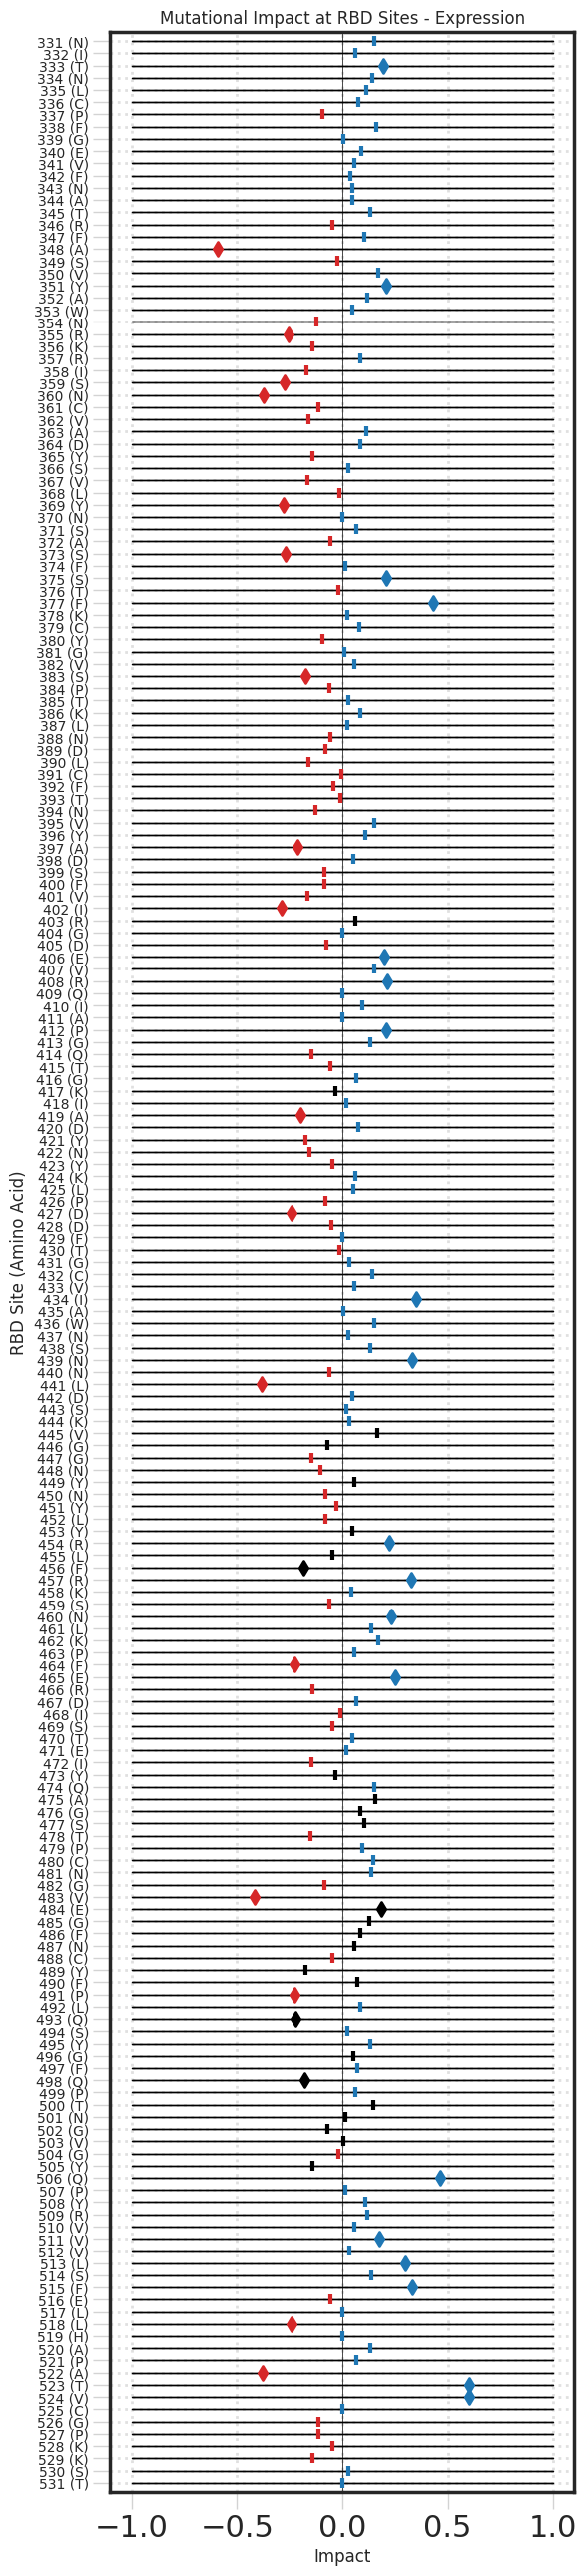

In [38]:
plot_mutational_impact(e_impact_results, "Expression", interface_residues)

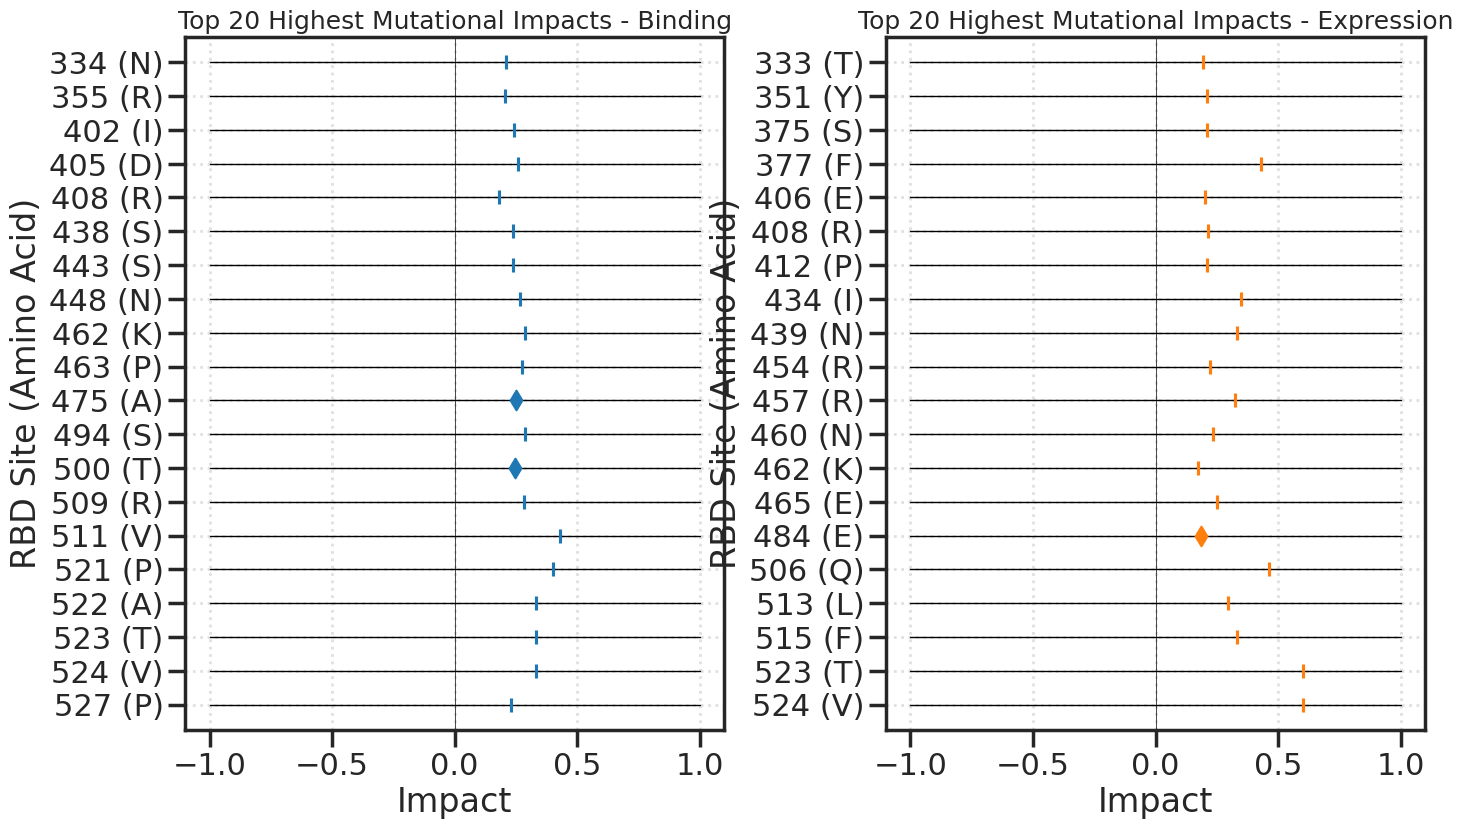

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mutational_impact_limited(ax, impact_results_df, rbd_sites, BorE, interface_residues):
    df = impact_results_df[impact_results_df['RBD Site'].isin(rbd_sites)].copy()
    df = df.sort_values('RBD Site', ascending=False).reset_index(drop=True)

    sns.set_style("ticks")
    sns.set_context("talk")

    # Track y-tick positions and labels
    yticks = []
    ytick_labels = []

    for i, row in df.iterrows():
        rbd_site = row['RBD Site']
        aa = row['Original Amino Acid']
        impact = row['impact']

        # Background horizontal reference line
        ax.plot([-1, 1], [i, i], color='black', linewidth=1, zorder=1)

        # Main scatter plot
        ax.scatter(
            impact,
            i,
            color='tab:blue' if BorE == 'Binding' else 'tab:orange',
            marker='d' if rbd_site in interface_residues else '|',
            s=100,
            zorder=3
        )

        yticks.append(i)
        ytick_labels.append(f"{rbd_site} ({aa})")

    # Axes config
    ax.set_title(f'Top 20 Highest Mutational Impacts - {BorE}')
    ax.set_xlabel('Impact')
    ax.set_ylabel('RBD Site (Amino Acid)')
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)
    ax.set_ylim(-0.75, len(yticks) - 0.25)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(True, linestyle=':', color='lightgrey', alpha=0.7)

fig, axs = plt.subplots(1, 2, figsize=(16, 9), sharex=True)
fig.subplots_adjust(wspace=0.3)  # Reduce the horizontal space between subplots

# Binding sites
binding_rbd_sites = [
    334, 355, 402, 405, 408, 438, 443, 448, 462, 463, 475, 494, 500, 509, 511, 521, 522, 523, 524, 527
]
plot_mutational_impact_limited(axs[0], b_impact_results, binding_rbd_sites, "Binding", interface_residues)

# Expression sites
expression_rbd_sites = [
    333, 351, 375, 377, 406, 408, 412, 434, 439, 454, 457, 460, 462, 465, 484, 506, 513, 515, 523, 524
]
plot_mutational_impact_limited(axs[1], e_impact_results, expression_rbd_sites, "Expression", interface_residues)

plt.savefig("mutation/mutational_impact_limited.G.pdf", bbox_inches='tight')
plt.savefig("mutation/mutational_impact_limited.G.png", bbox_inches='tight')

## ESM-GCN
Histogram figure of frequent mutations for ESM-GCN, version C. We'll choose this model version because it was the best performance between binding and expression, especially compared to the BE model versions. We won't be grabbing the mutation impact figure for this though.

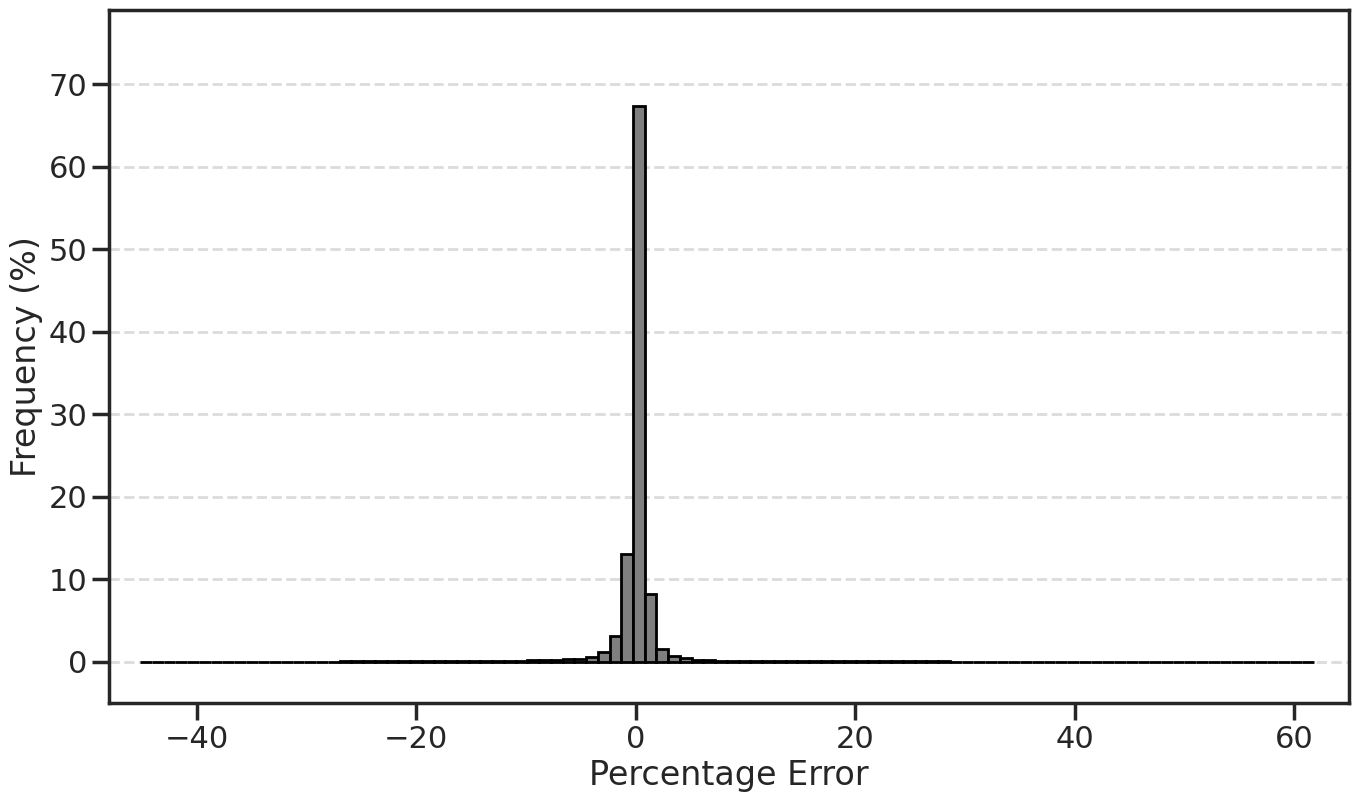

In [40]:
import pandas as pd
log_dir = "../../src/pnlp/ESM_TL/logs/"
info_df = pd.read_csv("/data/spike_ml/Spike_NLP-Lightning/notebooks/models/scatter/ESM_TL/esm_gcn/esm_gcn.C.binding-predicted_vs_measured.values.csv")

# Binding
binding_df = info_df[["seq_id", "predicted_value", "measured_value", "mode"]].copy()
binding_df["percentage_error"] = ((info_df["predicted_value"] - info_df["measured_value"]) / info_df["measured_value"]) * 100
binding_df.head(5)

# Plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')
sns.set_context('poster')
plt.subplots(figsize=(16, 9)) 

plt.hist(
    binding_df["percentage_error"], 
    bins=100, 
    weights=[100 / len(binding_df)] * len(binding_df), 
    edgecolor='black', 
    color='tab:grey',
    #linewidth=1
)

plt.xlim(-48, 65)  
plt.xlabel("Percentage Error")
plt.ylim(-5, 79)
plt.ylabel("Frequency (%)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

save_path = "bar/esm_gcn.C.binding-percent_error"
plt.savefig(f"{save_path}.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.savefig(f"{save_path}.png", format='png', dpi=300, bbox_inches='tight')

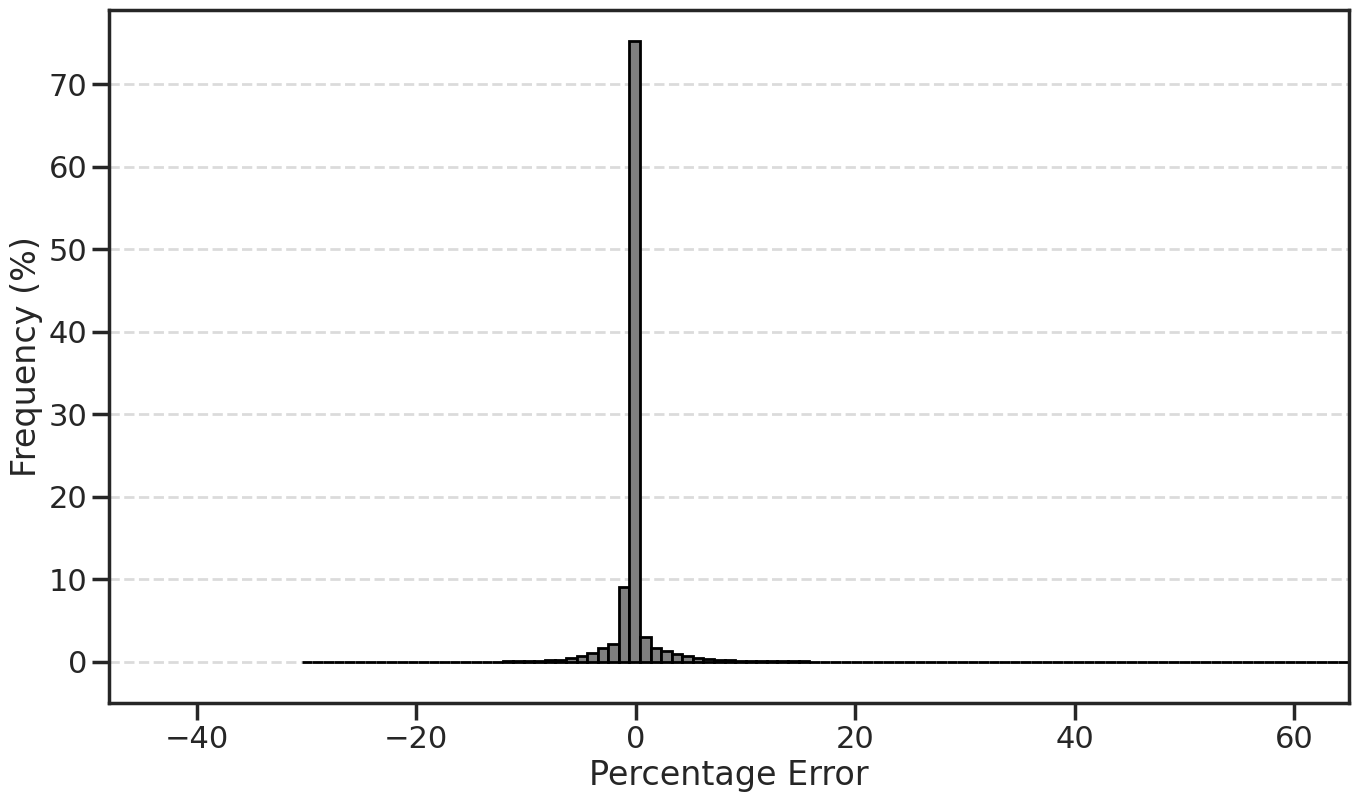

In [41]:
import pandas as pd
log_dir = "../../src/pnlp/ESM_TL/logs/"
info_df = pd.read_csv("/data/spike_ml/Spike_NLP-Lightning/notebooks/models/scatter/ESM_TL/esm_gcn/esm_gcn.C.expression-predicted_vs_measured.values.csv")

# Expression
expression_df = info_df[["seq_id", "predicted_value", "measured_value", "mode"]].copy()
expression_df["percentage_error"] = ((info_df["predicted_value"] - info_df["measured_value"]) / info_df["measured_value"]) * 100
expression_df.head(5)

# Plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')
sns.set_context('poster')
plt.subplots(figsize=(16, 9)) 

plt.hist(
    expression_df["percentage_error"], 
    bins=100, 
    weights=[100 / len(expression_df)] * len(expression_df), 
    edgecolor='black', 
    color='tab:grey',
    # linewidth=1
)

plt.xlim(-48, 65)  
plt.xlabel("Percentage Error")
plt.ylim(-5, 79)
plt.ylabel("Frequency (%)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

save_path = "bar/esm_gcn.C.expression-percent_error"
plt.savefig(f"{save_path}.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.savefig(f"{save_path}.png", format='png', dpi=300, bbox_inches='tight')

## ESM-BLSTM_BE
Histogram figure of frequent mutations for ESM-BLSTM BE, version G. We'll choose this model version because it was the best performance between binding and expression.We won't be grabbing the mutation impact figure for this though.

In [42]:
import pandas as pd

log_dir = "../../src/pnlp/ESM_TL/logs/"

info_df = pd.read_csv("/data/spike_ml/Spike_NLP-Lightning/notebooks/models/scatter/ESM_TL/esm_blstm_be/esm_blstm_be.G-predicted_vs_measured.values.csv")
info_df.head(5)

,seq_id,binding_measured_value,binding_predicted_value,expression_measured_value,expression_predicted_value,mode
0,SARS-CoV-2-T63S_Y121P_T201S,9.380,9.494134,9.07,9.109378,test
1,SARS-CoV-2-S36E_Y143L,10.270,10.163922,9.85,10.226576,test
2,SARS-CoV-2-Y39L_F99C,8.985,8.137718,8.28,8.000989,test
3,SARS-CoV-2-V11C_I104Y,9.590,9.764849,7.68,7.988410,test
4,SARS-CoV-2-K56L_D90T,10.290,10.314124,9.36,9.186408,test


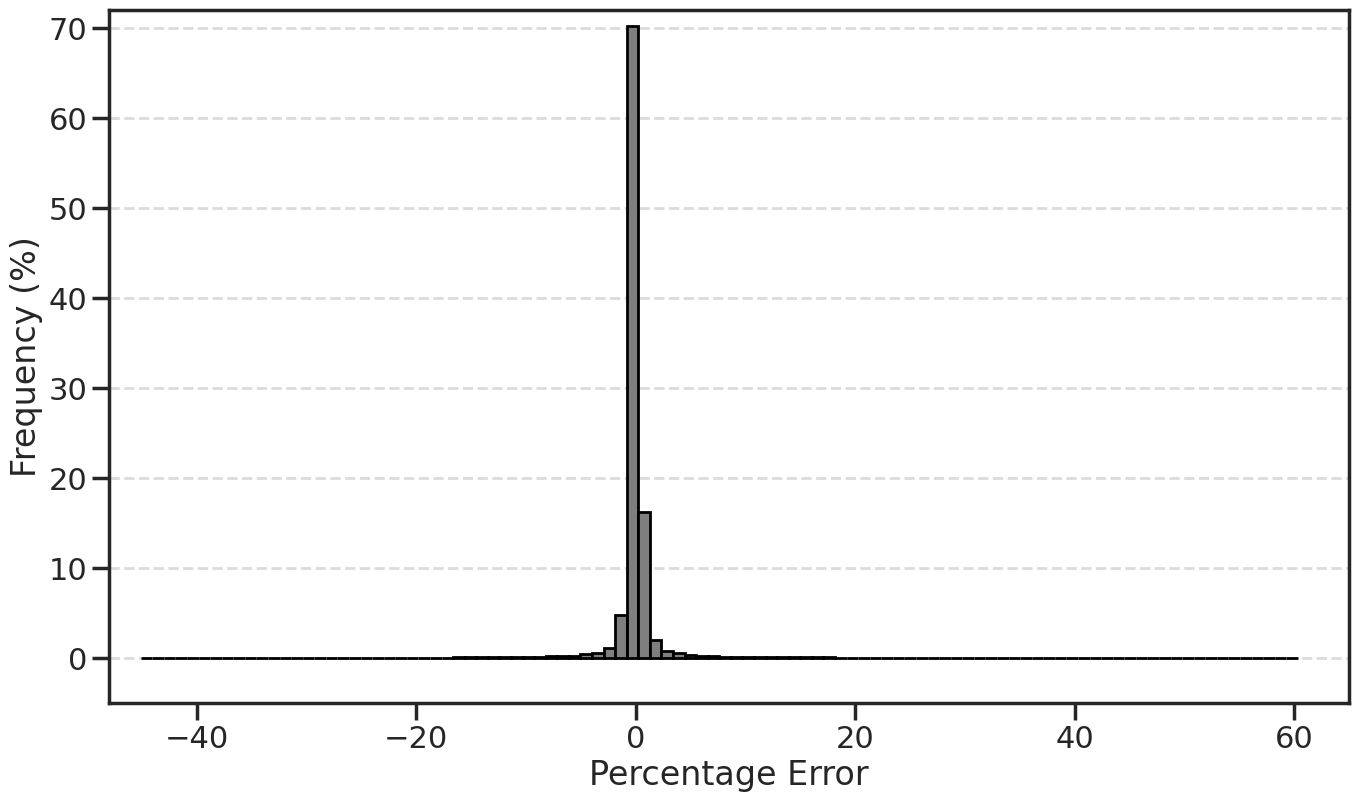

In [43]:
# Binding
binding_df = info_df[["seq_id", "binding_predicted_value", "binding_measured_value", "mode"]].copy()
binding_df["percentage_error"] = ((info_df["binding_predicted_value"] - info_df["binding_measured_value"]) / info_df["binding_measured_value"]) * 100
binding_df.head(5)

# Plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')
sns.set_context('poster')
plt.subplots(figsize=(16, 9)) 

plt.hist(
    binding_df["percentage_error"], 
    bins=100, 
    weights=[100 / len(binding_df)] * len(binding_df), 
    edgecolor='black', 
    color='tab:grey',
    #linewidth=1
)

plt.xlim(-48, 65)  
plt.xlabel("Percentage Error")
plt.ylim(-5, 72)
plt.ylabel("Frequency (%)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

save_path = "bar/esm_blstm_be.G.binding-percent_error"
plt.savefig(f"{save_path}.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.savefig(f"{save_path}.png", format='png', dpi=300, bbox_inches='tight')

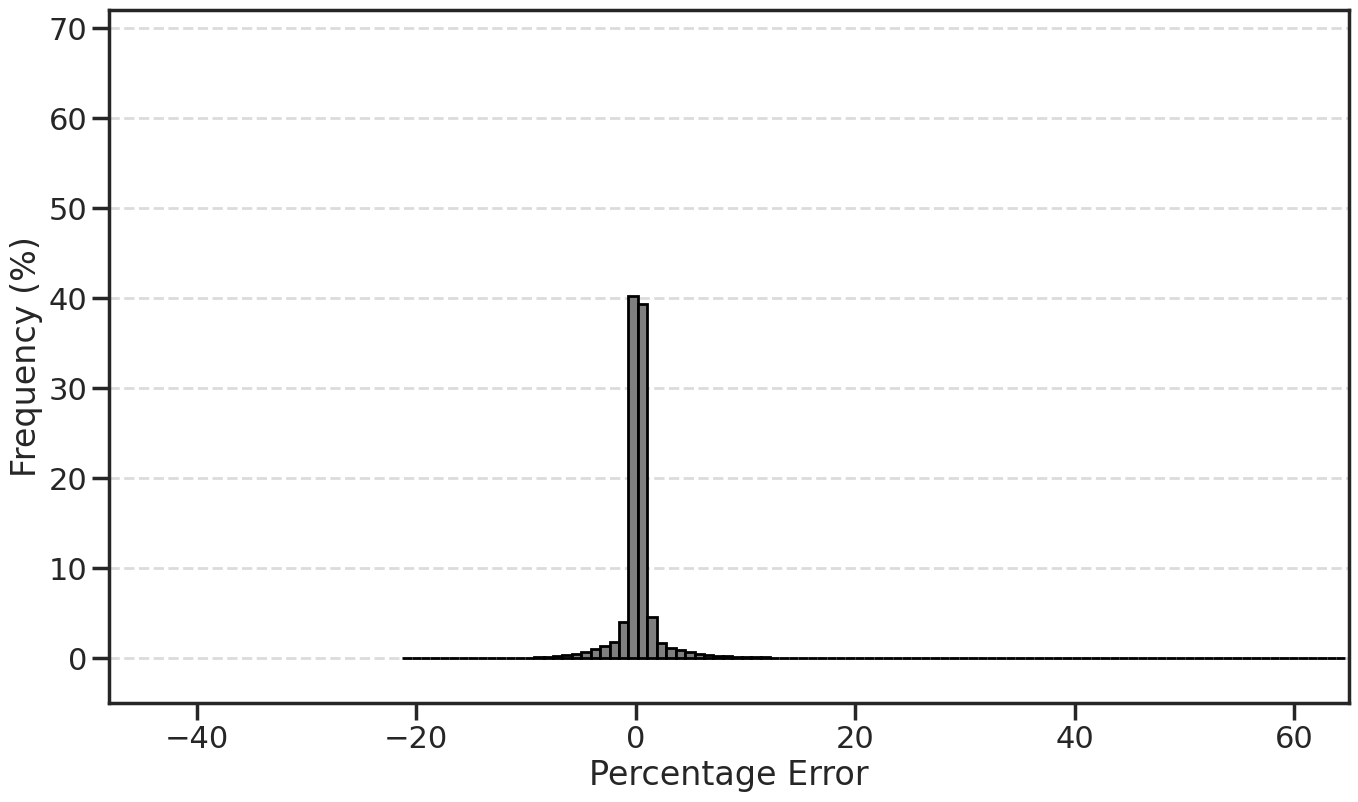

In [44]:
# Expression
expression_df = info_df[["seq_id", "expression_predicted_value", "expression_measured_value", "mode"]].copy()
expression_df["percentage_error"] = ((info_df["expression_predicted_value"] - info_df["expression_measured_value"]) / info_df["expression_measured_value"]) * 100
expression_df.head(5)

# Plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')
sns.set_context('poster')
plt.subplots(figsize=(16, 9)) 

plt.hist(
    expression_df["percentage_error"], 
    bins=100, 
    weights=[100 / len(expression_df)] * len(expression_df), 
    edgecolor='black', 
    color='tab:grey',
    # linewidth=1
)

plt.xlim(-48, 65)  
plt.xlabel("Percentage Error")
plt.ylim(-5, 72)
plt.ylabel("Frequency (%)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

save_path = "bar/esm_blstm_be.G.expression-percent_error"
plt.savefig(f"{save_path}.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.savefig(f"{save_path}.png", format='png', dpi=300, bbox_inches='tight')